<a href="https://colab.research.google.com/github/restful3/ds4th_study/blob/main/code_wooseok/Chest_X_Ray_%EC%82%AC%EC%A7%84%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 준비

## 목적 : 흉부 엑스선 이미지를 보고 폐렴을 진단하는 모델을 생성 (이진분류)
## 주요사항
|항목|내용|
|-|-|
|유형 및 평가지표|이진분류, 정확도, 재현율 , F1 점수|
|데이터준비|ImageFolder|
|모델|EfficientNet-B0,B1,B2,B3,앙상블|
|훈련|훈련함수 작성|
|예측|예측함수 작성|

In [1]:
# https://soohee410.github.io/colab_kaggle 에서 설정방법에 따라 데이터셋을 구글드라이브에 다운 받고 아래의 환경설정으로 따라 하세요 
# 파일 - 사본으로 저장하기로 복사하세요
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/SelfStudy/캐글스터디/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
data_path = '/content/drive/MyDrive/SelfStudy/캐글스터디/chest_xray/'
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

# 데이터탐색

In [2]:
from glob import glob

print(f'훈련 데이터 개수 : {len(glob(train_path + "*/*"))}')
print(f'검증 데이터 개수 : {len(glob(valid_path + "*/*"))}')
print(f'테스트 데이터 개수 : {len(glob(test_path + "*/*"))}')


훈련 데이터 개수 : 5216
검증 데이터 개수 : 16
테스트 데이터 개수 : 624


In [3]:
all_normal_imgs = []    # 모든 정상 이미지를 담을 리스트 초기화
all_pneumonia_imgs = [] # 모든 폐렴 이미지를 담을 리스트 초기화

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = data_path + cat
    # 정상, 폐렴 이미지 경로
    normal_imgs = glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs = glob(data_cat_path + 'PNEUMONIA/*')
    # 정상, 폐렴 이미지 경로를 리스트에 추가
    all_normal_imgs.extend(normal_imgs)
    all_pneumonia_imgs.extend(pneumonia_imgs)

print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수 : 4273


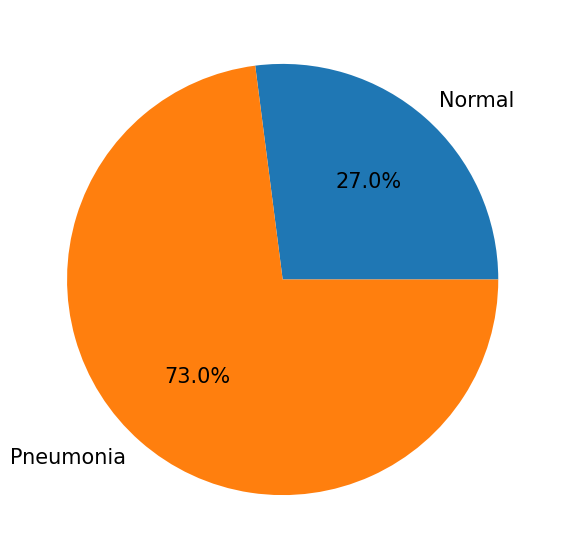

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Normal', 'Pneumonia'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)], 
        labels=label, 
        autopct='%.1f%%');

In [6]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3): 
    assert len(img_paths) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8)) 
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

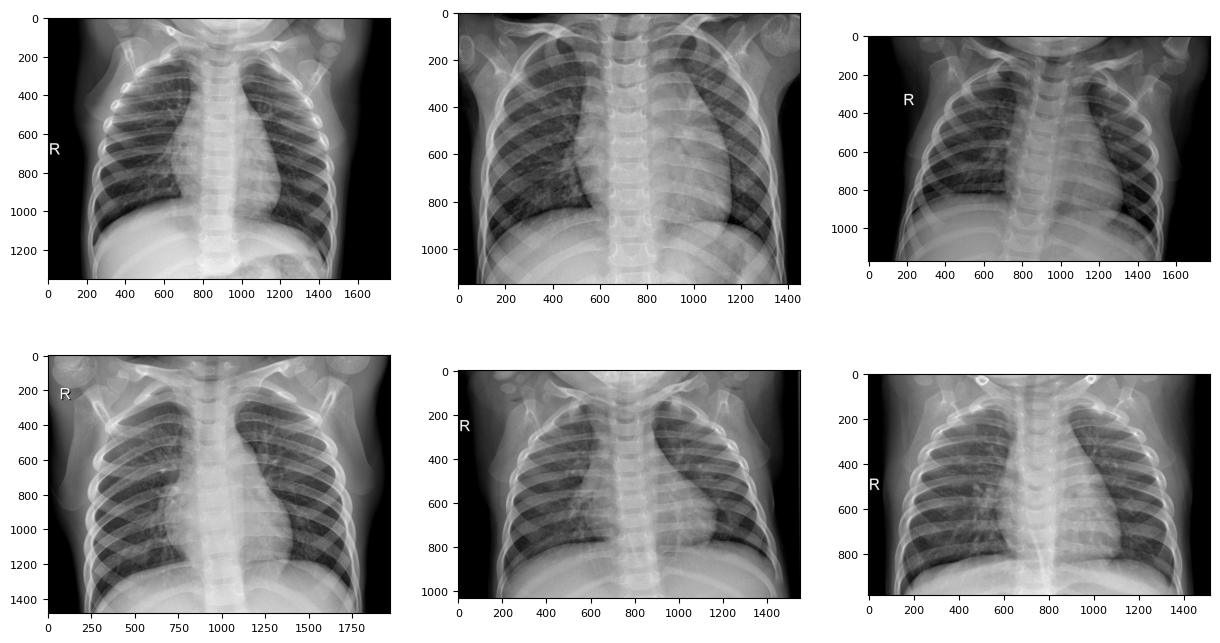

In [7]:
# 정상 엑스선 이미지 경로(마지막 6장)
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

# 이미지 출력
show_image(normal_img_paths)

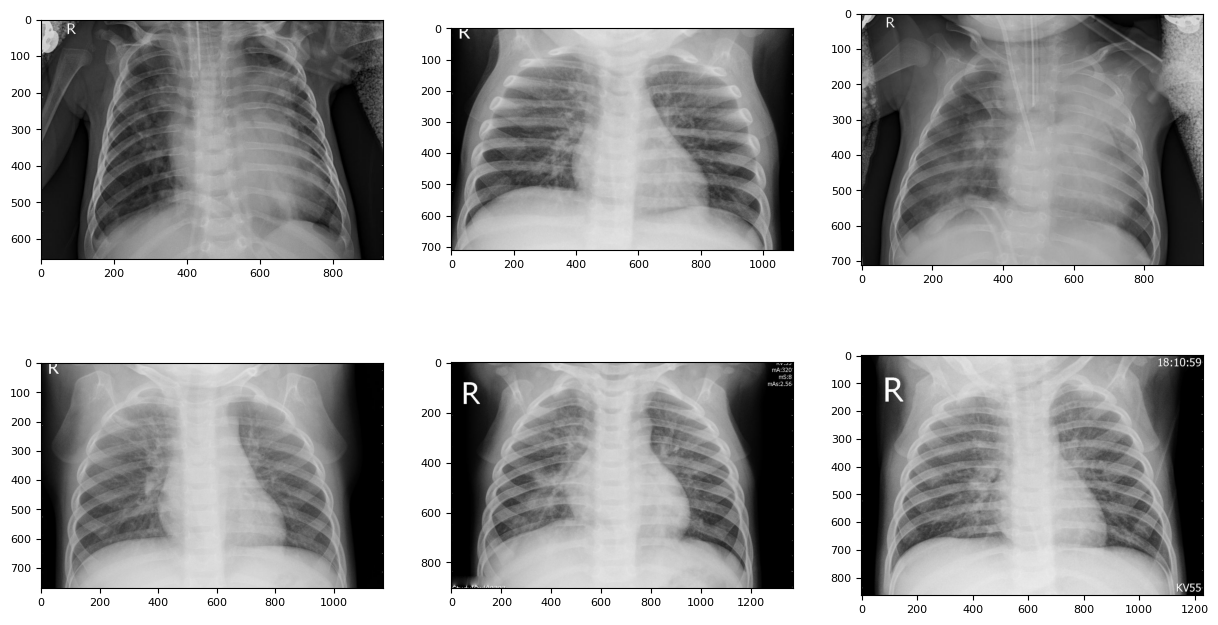

In [ ]:
# 폐렴 엑스선 이미지 경로(마지막 6장)
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]

# 이미지 출력
show_image(pneumonia_img_paths)

# 데이터 준비

In [8]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

In [9]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

In [10]:
import torch  
import random
import numpy as np
import os

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [21]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

# 베이스모델

## 모델학습

In [14]:
import os, sys
# # from google.colab import drive

# # drive.mount('content/drive')

save_path = '/content/drive/MyDrive/Colab Notebooks/venv'
my_path = '/content/my_env'
# os.symlink(save_path, my_path)
sys.path.insert(0, my_path)
# !pip install efficientnet-pytorch==0.7.1 
# !pip install --target=$my_path efficientnet-pytorch==0.7.1 


> colab에 기본으로 설치된 라이브러리(예>scikit-learn 등)는 충돌이 날수도 있으므로 별도 설치하지 않는다

In [16]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2) 
# 장비 할당
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [14]:
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

모델 파라미터 개수 : 4010110


In [15]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대
import os

path = '/content/drive/MyDrive/SelfStudy/캐글스터디/chest_xray/model'
os.makedirs(path, exist_ok=True)

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file=f'{path}/model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [ ]:
# # 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer,
                         epochs=2)

에폭 [1/2] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4836
	검증 데이터 손실값 : 3.9039
	정확도 : 0.5000 / 재현율 : 1.0000 / F1 점수 : 0.6667
	### 검증 데이터 손실값 감소 (inf --> 7.8078). 모델 저장
에폭 [2/2] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2707
	검증 데이터 손실값 : 1.5257
	정확도 : 0.4375 / 재현율 : 0.7500 / F1 점수 : 0.5714
	### 검증 데이터 손실값 감소 (7.8078 --> 3.0514). 모델 저장


In [ ]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 예측 및 평가

In [29]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [28]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list


In [ ]:
true_list, preds_list = predict(model=model, 
                                loader_test=loader_test, 
                                return_true=True)

In [ ]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.6907
재현율 : 0.9359
F1 점수 : 0.7909


# 성능개선
모델 앙상블을 통해 성능 개선 : 1~3번 까지의 모델을 생성하고 , 학습 후 앙상블한다

In [17]:

from efficientnet_pytorch import EfficientNet
model_list = []
# 모델생성
en_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
en_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
en_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2)
# 장비할당
en_b1 = en_b1.to(device)
en_b2 = en_b2.to(device)
en_b3 = en_b3.to(device)
# 리스트에모델저장
model_list.append(en_b1)
model_list.append(en_b2)
model_list.append(en_b3)
# 파라미터수 확인
for idx, model in enumerate(model_list):
  num_params = sum(param.numel() for param in model.parameters())
  print(f' 모델{idx+1} 파라미터 개수 : {num_params}')





Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
 모델1 파라미터 개수 : 6515746
 모델2 파라미터 개수 : 7703812
 모델3 파라미터 개수 : 10699306


ADAM 에 가중치 감쇠를 주는 ADAMW를 이용

In [18]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.AdamW(model_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(model_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(model_list[2].parameters(), lr=0.0006, weight_decay=0.001)


get_cosine_schdule_with_warmup() 메소드를 사용하여 스케줄러 생성

In [19]:
# !pip install --target=$my_path transformers
from transformers import get_cosine_schedule_with_warmup

In [22]:
epochs = 20
scheduler1 = get_cosine_schedule_with_warmup(optimizer1,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps = len(loader_train)*epochs)
scheduler2 = get_cosine_schedule_with_warmup(optimizer2,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps = len(loader_train)*epochs)
scheduler3 = get_cosine_schedule_with_warmup(optimizer3,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps = len(loader_train)*epochs)
                                          

모델 훈련 및 최적 가중치 적용

In [23]:
model_state_dict = train(model=model_list[0],
                          loader_train =loader_train ,
                          loader_valid = loader_valid,
                          criterion = criterion,
                          optimizer= optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)
model_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3041
	검증 데이터 손실값 : 0.6958
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
	### 검증 데이터 손실값 감소 (inf --> 1.3916). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1431
	검증 데이터 손실값 : 0.2646
	정확도 : 0.8125 / 재현율 : 0.6250 / F1 점수 : 0.7692
	### 검증 데이터 손실값 감소 (1.3916 --> 0.5291). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1341
	검증 데이터 손실값 : 0.2427
	정확도 : 0.9375 / 재현율 : 0.8750 / F1 점수 : 0.9333
	### 검증 데이터 손실값 감소 (0.5291 --> 0.4853). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1088
	검증 데이터 손실값 : 0.3537
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0871
	검증 데이터 손실값 : 0.6553
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0693
	검증 데이터 손실값 : 0.0794
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.4853 --> 0.1588). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0696
	검증 데이터 손실값 : 0.4981
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0610
	검증 데이터 손실값 : 0.4069
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0540
	검증 데이터 손실값 : 0.3087
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0548
	검증 데이터 손실값 : 0.0530
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1588 --> 0.1060). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0400
	검증 데이터 손실값 : 1.1100
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0321
	검증 데이터 손실값 : 0.6548
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0315
	검증 데이터 손실값 : 0.2156
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0257
	검증 데이터 손실값 : 0.0551
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0170
	검증 데이터 손실값 : 0.5147
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0170
	검증 데이터 손실값 : 0.0258
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1060 --> 0.0516). 모델 저장
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0117
	검증 데이터 손실값 : 0.1080
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0104
	검증 데이터 손실값 : 0.0773
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0103
	검증 데이터 손실값 : 0.0580
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0064
	검증 데이터 손실값 : 0.0413
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000


<All keys matched successfully>

In [24]:
model_state_dict = train(model=model_list[1],
                          loader_train =loader_train ,
                          loader_valid = loader_valid,
                          criterion = criterion,
                          optimizer= optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)
model_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7086
	검증 데이터 손실값 : 0.6815
	정확도 : 0.5625 / 재현율 : 0.7500 / F1 점수 : 0.6316
	### 검증 데이터 손실값 감소 (inf --> 1.3631). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7067
	검증 데이터 손실값 : 0.6751
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
	### 검증 데이터 손실값 감소 (1.3631 --> 1.3502). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7059
	검증 데이터 손실값 : 0.6751
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
	### 검증 데이터 손실값 감소 (1.3502 --> 1.3502). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7065
	검증 데이터 손실값 : 0.6788
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7085
	검증 데이터 손실값 : 0.6753
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7072
	검증 데이터 손실값 : 0.6752
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7068
	검증 데이터 손실값 : 0.6769
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7076
	검증 데이터 손실값 : 0.6775
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7066
	검증 데이터 손실값 : 0.6785
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7080
	검증 데이터 손실값 : 0.6783
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7067
	검증 데이터 손실값 : 0.6744
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
	### 검증 데이터 손실값 감소 (1.3502 --> 1.3487). 모델 저장
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7079
	검증 데이터 손실값 : 0.6732
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
	### 검증 데이터 손실값 감소 (1.3487 --> 1.3464). 모델 저장
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7095
	검증 데이터 손실값 : 0.6764
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7093
	검증 데이터 손실값 : 0.6746
	정확도 : 0.5000 / 재현율 : 0.5000 / F1 점수 : 0.5000
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7057
	검증 데이터 손실값 : 0.6740
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7050
	검증 데이터 손실값 : 0.6759
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7083
	검증 데이터 손실값 : 0.6752
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7089
	검증 데이터 손실값 : 0.6763
	정확도 : 0.5000 / 재현율 : 0.5000 / F1 점수 : 0.5000
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7088
	검증 데이터 손실값 : 0.6781
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7058
	검증 데이터 손실값 : 0.6760
	정확도 : 0.5625 / 재현율 : 0.5000 / F1 점수 : 0.5333


<All keys matched successfully>

In [27]:
model_state_dict = train(model=model_list[2],
                          loader_train =loader_train ,
                          loader_valid = loader_valid,
                          criterion = criterion,
                          optimizer= optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)
model_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7131
	검증 데이터 손실값 : 0.7367
	정확도 : 0.3750 / 재현율 : 0.6250 / F1 점수 : 0.5000
	### 검증 데이터 손실값 감소 (inf --> 1.4734). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7091
	검증 데이터 손실값 : 0.6960
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
	### 검증 데이터 손실값 감소 (1.4734 --> 1.3919). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7091
	검증 데이터 손실값 : 0.6944
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
	### 검증 데이터 손실값 감소 (1.3919 --> 1.3888). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7113
	검증 데이터 손실값 : 0.6948
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7104
	검증 데이터 손실값 : 0.6974
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7109
	검증 데이터 손실값 : 0.6926
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
	### 검증 데이터 손실값 감소 (1.3888 --> 1.3853). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7120
	검증 데이터 손실값 : 0.6961
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7102
	검증 데이터 손실값 : 0.6958
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7093
	검증 데이터 손실값 : 0.6957
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7115
	검증 데이터 손실값 : 0.6930
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7133
	검증 데이터 손실값 : 0.6922
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
	### 검증 데이터 손실값 감소 (1.3853 --> 1.3845). 모델 저장
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7102
	검증 데이터 손실값 : 0.6935
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7103
	검증 데이터 손실값 : 0.6902
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
	### 검증 데이터 손실값 감소 (1.3845 --> 1.3804). 모델 저장
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7122
	검증 데이터 손실값 : 0.6957
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7062
	검증 데이터 손실값 : 0.6955
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7111
	검증 데이터 손실값 : 0.6948
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7113
	검증 데이터 손실값 : 0.6946
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7109
	검증 데이터 손실값 : 0.6919
	정확도 : 0.6250 / 재현율 : 0.7500 / F1 점수 : 0.6667
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7111
	검증 데이터 손실값 : 0.6941
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7117
	검증 데이터 손실값 : 0.6967
	정확도 : 0.5625 / 재현율 : 0.6250 / F1 점수 : 0.5882


<All keys matched successfully>

In [30]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)
loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size,
                         shuffle= False, worker_init_fn = seed_worker, 
                         generator=g, num_workers=2)
true,preds1 = predict(model=model_list[0],
                      loader_test=loader_test,
                      return_true=True)
preds2 = predict(model=model_list[1],
                      loader_test=loader_test)
preds3 = predict(model=model_list[2],
                      loader_test=loader_test)

In [31]:
ac= []
rc= []
f1= []
pr = [preds1,preds2, preds3]
for p in pr:
  ac.append(accuracy_score(true,p))
  rc.append(recall_score(true,p))
  f1.append(f1_score(true,p))
import pandas as pd
df = pd.DataFrame({'정확도':ac,'재현율':rc,'f1':f1},index=['b1','b2','b3'])
df


,정확도,재현율,f1
b1,0.852564,0.992308,0.893764
b2,0.608974,0.828205,0.725843
b3,0.592949,0.561538,0.632948


In [53]:
ensemble_preds = []
for i in range(len(preds1)):
  pred_element = np.round((preds1[i]+preds2[i])/2)
  ensemble_preds.append(pred_element)
  

In [54]:
ensemble_score = {'정확도':accuracy_score(true,ensemble_preds),
                  '재현율':recall_score(true,ensemble_preds),
                  'f1':f1_score(true,ensemble_preds)}
pd.concat([df,pd.DataFrame([ensemble_score])])


,정확도,재현율,f1
b1,0.852564,0.992308,0.893764
b2,0.608974,0.828205,0.725843
b3,0.592949,0.561538,0.632948
0,0.778846,0.820513,0.822622


,정확도,재현율,f1
0,0.759615,0.912821,0.825986


## 별첨] 준비과정 정리

In [ ]:
## /content/drive/MyDrive/SelfStudy/캐글스터디/ 를  관리할 폴더로 가정하여 작성햇습니다.

# from google.colab import drive
# drive.mount('/content/drive') # 드라이브 장착합니다.

# from google.colab import files
# files.upload()  # kaggle.json을 업로드 합니다.

# !cp /content/kaggle.json /content/drive/MyDrive/SelfStudy/캐글스터디/ # 키 이동

# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/SelfStudy/캐글스터디/'


# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip /content/chest-xray-pneumonia.zip -d /content/drive/MyDrive/SelfStudy/캐글스터디/ # 집파일을 해제합니다.


[colab의 패키지 영구사용법](https://dacon.io/codeshare/4200)

In [ ]:
# # colab의 패키지 영구사용법 
import os, sys
# from google.colab import drive
# drive.mount('content/drive')
save_path = '/content/drive/MyDrive/Colab Notebooks/venv'
my_path = '/content/my_env'
os.symlink(save_path, my_path)
sys.path.insert(0, my_path)
